<a href="https://colab.research.google.com/github/ravichoudharyds/Natural-Language-Processing/blob/master/HW5/NLP_HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 5: Machine Reading

## 1. Random QA

1) What is the probability $p_{k,n}$ that our random QA system will output an answer with $k$ tokens when given a context paragraph with $n$ token as input?

$$p_{k,n} = \frac{2*(n-k+1)}{n*(n+1)} $$

2) For a fixed $n$ of $100$, produce a plot of $p_{k,n}$ and $\hat{p}_{k,n}$  vs $k$. Design a monte-carlo experiment to estimate the values for $\hat{p}_{k,n}$.

In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:
def func_p_k_n(k, n):
    #implement answer from part 1 here
    return 2*(n-k+1)/(n*(n+1))

In [0]:
def monte_carlo_p_k_n(k, n, T = int(1e5)):
    #T is the number of times you run experiment
    count = 0
    for _ in range(T):
        a,b = np.random.choice(n,size=2,replace=True)
        while a>b: #adding this part
            a,b = np.random.choice(n,size=2,replace=True)
        #if np.abs(b - a)+1 == k:
        if b - a + 1 == k:
            count = count + 1
    return count/T

In [0]:
k_array = np.arange(1, 100, 5)
p_k_n_hat = [monte_carlo_p_k_n(k, n=100, T = int(1e5)) for k in k_array]
p_k_n = [func_p_k_n(k, n=100) for k in k_array]

#k_array = np.arange(1, 4+1)
#p_k_n_hat = [monte_carlo_p_k_n(k, n=4, T = int(1e5)) for k in k_array]
#p_k_n = [func_p_k_n(k, n=4) for k in k_array]

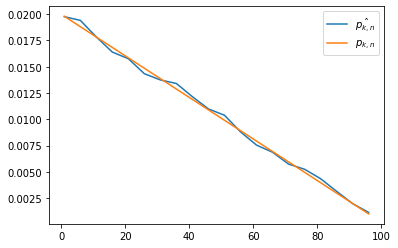

In [0]:
plt.plot(k_array, p_k_n_hat, label = r'$\hat{p_{k,n}}$')
plt.plot(k_array, p_k_n, label = r'$p_{k, n}$')
plt.legend()
plt.show()

3) Calculate the expected length of the answer given by your random QA system. i,e write an expression for $L_n = E[K]$ (It's fine to leave it as a summation).

$$ L_n = \sum_{k=1}^n\frac{2*(n-k+1)}{n*(n+1)}*k$$

4) Plot $\hat{L_n}$ estimated through monte-carlo simulations and $L_n$ for $n = 5, 10, 25, 50, 100, 250$ and $500$.

In [0]:
def L_n(n):
    #implement answer from above
    l_n = 0
    for k in range(n):
        l_n += 2*(n-k+1)/(n*(n+1))*k
    return l_n

def monte_carlo_L_n(n, T = int(1e5)):
    #T is the number of times you run experiment
    arr = np.zeros(n)
    l_n = 0
    for i in range(T):
        a,b = np.random.choice(n,size=2,replace=True)
        while a>b: #adding this part
            a,b = np.random.choice(n,size=2,replace=True)
        #arr[np.abs(b-a)] += 1
        arr[b-a] += 1
    for i in range(n):
        l_n += (i+1)*arr[i]
    return l_n/T

In [0]:
n_array = [5, 10, 25, 50, 100, 250, 500]
#n_array = [4, 5, 6]
l_n_hat = [monte_carlo_L_n(n, T = int(1e5)) for n in n_array]
l_n = [L_n( n) for n in n_array]

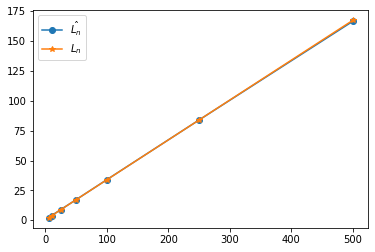

In [0]:
plt.plot(n_array, l_n_hat, '-o', label = r'$\hat{L_n}$')
plt.plot(n_array, l_n,  '-*', label = r'$L_n$')
plt.legend()
plt.show()

5) Calculate the probability, $p_n$ that Random QA system outputs the correct answer to your question. 

$$p_n = \frac{2}{n(n+1)}$$

6)  In SQuAD 2.0 data set, the answer for your question can either lie within the context paragraph or there could be no answer within the given paragraph. Let $\alpha$ represent the fraction of questions for which the answer \textbf{does not} lie within the paragraph.

In [0]:
## load dataset 

import os
import sys
import json
from google.colab import drive
drive.mount('/content/drive')
module_path = os.path.abspath(os.path.join('/content/drive/My Drive/NLP_HW/HW5/'))
if module_path not in sys.path:
    sys.path.append(module_path)
DIR = '/content/drive/My Drive/NLP_HW/HW5/'
train_path = os.path.join(DIR, 'squad/data/train-v2.0.json')
train_data=json.load(open(train_path,"rb"))
dev_path = os.path.join(DIR, 'squad/data/dev-v2.0.json')
dev_data=json.load(open(dev_path,"rb"))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#preprocess data
import spacy
import string

In [0]:
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation

# lowercase and remove punctuation
def tokenize(sent):
    tokens = tokenizer(sent)
    return [token.text.lower() for token in tokens if (token.text not in punctuations)]

In [0]:
from tqdm import tqdm

def process_for_rand(dataset):
    dataset=dataset["data"]
    data_flat=[]
    for entry in tqdm(dataset):
        paragraphs=entry["paragraphs"]
        for para in paragraphs:
            context=para["context"]
            questions=para["qas"]
            for quest in questions:
                example={}
                example["context"]=tokenize(context) #may want to just split instead of tokenize
                example["is_impossible"]=quest["is_impossible"]
                if not quest["is_impossible"]:
                    example["answers"]=[answer["text"] for answer in quest["answers"]]
                else:
                    example["answers"]=[]
                data_flat.append(example)
    return data_flat

In [0]:
train_flat=process_for_rand(train_data)
dev_flat=process_for_rand(dev_data) 


100%|██████████| 442/442 [44:18<00:00,  4.88s/it]

100%|██████████| 16/16 [02:17<00:00,  8.75s/it]


In [0]:
def estimate_alpha(list_of_answers):
    L=len(list_of_answers)
    a=0
    for entry in list_of_answers:
        if entry["is_impossible"]:
            a+=1
    alpha=a/L
    return alpha

In [0]:
alpha_hat_train=estimate_alpha(train_flat)
print("Alpha from dtrain",alpha_hat_train)
alpha_hat_dev=estimate_alpha(dev_flat)
print("Alpha from dev",alpha_hat_dev)

Alpha from dtrain 0.3337809528925176
Alpha from dev 0.5212240868706811


In [0]:
## implement random QA model
def random_QA(data,alpha=-1):
    if alpha==-1:
        alpha=estimate_alpha(data)
    for question in data:
        if np.random.rand()>alpha:
            n=len(question["context"])
            s,e=np.random.choice(n,size=2,replace=True)
            while s>e:
                s,e=np.random.choice(n,size=2,replace=True)
            pred=" ".join(question["context"][s:e+1])#probably need to adjust for data format
        else:
            pred=[]
        question["prediction"]=pred
    return data

In [0]:
#Note: This cell is copied from squad.util.py, I don't have it linked so I just copied and pasted

import re
from collections import Counter

def normalize_answer(s):
    """Convert to lowercase and remove punctuation, articles and extra whitespace."""

    def remove_articles(text):
        regex = re.compile(r'\b(a|an|the)\b', re.UNICODE)
        return re.sub(regex, ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

def get_tokens(s):
    if not s:
        return []
    return normalize_answer(s).split()
    
def compute_em(a_gold, a_pred):
    gold_toks = get_tokens(a_gold)
    pred_toks = get_tokens(a_pred)
    return int(gold_toks == pred_toks)

def compute_f1(a_gold, a_pred):
    gold_toks = get_tokens(a_gold)
    pred_toks = get_tokens(a_pred)
    common = Counter(gold_toks) & Counter(pred_toks)
    num_same = sum(common.values())
    if len(gold_toks) == 0 or len(pred_toks) == 0:
        # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
        return int(gold_toks == pred_toks)
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(pred_toks)
    recall = 1.0 * num_same / len(gold_toks)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

def metric_max_over_ground_truths(metric_fn, prediction, ground_truths):
    if not ground_truths:
        return metric_fn(prediction, '')
    scores_for_ground_truths = []
    for ground_truth in ground_truths:
        score = metric_fn(prediction, ground_truth)
        scores_for_ground_truths.append(score)
    return max(scores_for_ground_truths)
    

In [0]:
import numpy as np

## find F1 and EM on Dev Set
F1=np.zeros(100)
EM=np.zeros(100)
for i in range(100):
    dev_pred=random_QA(dev_flat, alpha=alpha_hat_train)
    n=len(dev_pred)
    for entry in dev_pred:
        f1=metric_max_over_ground_truths(compute_f1, entry["prediction"], entry["answers"])
        F1[i]+=f1/n
        em=metric_max_over_ground_truths(compute_em, entry["prediction"], entry["answers"])
        EM[i]+=em/n
mean_f1=np.mean(F1)
std_f1=np.std(F1)
mean_em=np.mean(EM)
std_em=np.std(EM)
print("F1: mean",mean_f1,"std",std_f1,"EM: mean",mean_em,"std",std_em)

F1: mean 0.20012870638238212 std 0.004118457489855428 EM: mean 0.1754228364593569 std 0.004085168086318939



##### F1 Score on Dev Set: $0.28994 \pm 0.00485$
##### EM on Dev Set: $0.27228 \pm 0.00472$

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


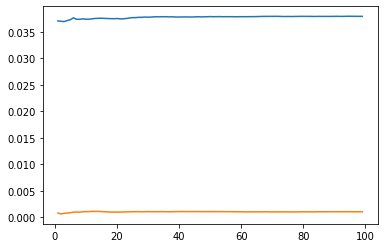

In [0]:
import matplotlib.pyplot as plt

rrr=np.arange(100)
plt.plot(rrr,[np.mean(F1[:i]) for i in range(len(F1))])
plt.plot(rrr,[np.mean(EM[:i]) for i in range(len(EM))])


## RNN Based Model

### 2.1.1 Diagram of Baseline

In [0]:
from IPython.display import Image

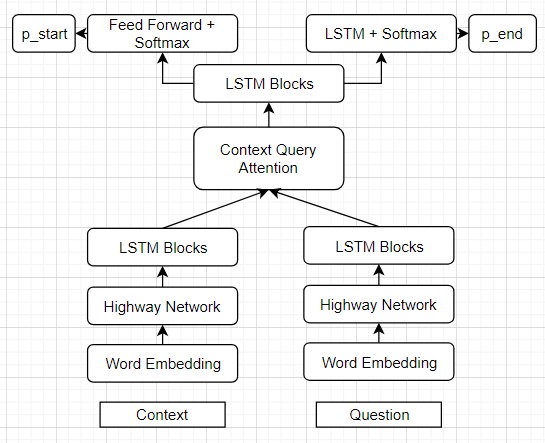

In [0]:
Image('https://raw.githubusercontent.com/ravichoudharyds/Natural-Language-Processing/master/HW5/bidaf_baseline.PNG')

### 2.1.2 Performance of Baseline

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install ujson

     |████████████████████████████████| 194kB 2.8MB/s 
  Created wheel for ujson: filename=ujson-1.35-cp36-cp36m-linux_x86_64.whl size=68020 sha256=ba21d17bc2ea426ff76b36e0dbdbc0652ccffa5d3b9707f20b16eaea41d075b4
  Stored in directory: /root/.cache/pip/wheels/28/77/e4/0311145b9c2e2f01470e744855131f9e34d6919687550f87d1
Successfully built ujson


In [0]:
import os
import sys
module_path = os.path.abspath(os.path.join('/content/drive/My Drive/NLP_HW/HW5/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as sched
import torch.utils.data as data

from squad.util import collate_fn, SQuAD
from collections import OrderedDict
from json import dumps
from tqdm import tqdm
from ujson import load as json_load
from squad import util, layers
import os
import copy

DIR = '/content/drive/My Drive/NLP_HW/HW5/'
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [0]:
class BiDAF(nn.Module):
    """Baseline BiDAF model for SQuAD.

    Based on the paper:
    "Bidirectional Attention Flow for Machine Comprehension"
    by Minjoon Seo, Aniruddha Kembhavi, Ali Farhadi, Hannaneh Hajishirzi
    (https://arxiv.org/abs/1611.01603).

    Follows a high-level structure commonly found in SQuAD models:
        - Embedding layer: Embed word indices to get word vectors.
        - Encoder layer: Encode the embedded sequence.
        - Attention layer: Apply an attention mechanism to the encoded sequence.
        - Model encoder layer: Encode the sequence again.
        - Output layer: Simple layer (e.g., fc + softmax) to get final outputs.

    Args:
        word_vectors (torch.Tensor): Pre-trained word vectors.
        hidden_size (int): Number of features in the hidden state at each layer.
        drop_prob (float): Dropout probability.
    """
    def __init__(self, word_vectors, hidden_size, drop_prob=0.):
        super(BiDAF, self).__init__()
        self.emb = layers.Embedding(word_vectors=word_vectors,
                                    hidden_size=hidden_size,
                                    drop_prob=drop_prob)

        self.enc = layers.RNNEncoder(input_size=hidden_size,
                                     hidden_size=hidden_size,
                                     num_layers=1,
                                     drop_prob=drop_prob)

        self.att = layers.BiDAFAttention(hidden_size=2 * hidden_size,
                                         drop_prob=drop_prob)

        self.mod = layers.RNNEncoder(input_size=8 * hidden_size,
                                     hidden_size=hidden_size,
                                     num_layers=2,
                                     drop_prob=drop_prob)

        self.out = layers.BiDAFOutput(hidden_size=hidden_size,
                                      drop_prob=drop_prob)

    def forward(self, cw_idxs, qw_idxs):
        c_mask = torch.zeros_like(cw_idxs) != cw_idxs
        q_mask = torch.zeros_like(qw_idxs) != qw_idxs
        c_len, q_len = c_mask.sum(-1), q_mask.sum(-1)

        c_emb = self.emb(cw_idxs)         # (batch_size, c_len, hidden_size)
        q_emb = self.emb(qw_idxs)         # (batch_size, q_len, hidden_size)

        c_enc = self.enc(c_emb, c_len)    # (batch_size, c_len, 2 * hidden_size)
        q_enc = self.enc(q_emb, q_len)    # (batch_size, q_len, 2 * hidden_size)

        att = self.att(c_enc, q_enc,
                       c_mask, q_mask)    # (batch_size, c_len, 8 * hidden_size)

        mod = self.mod(att, c_len)        # (batch_size, c_len, 2 * hidden_size)

        out = self.out(att, mod, c_mask)  # 2 tensors, each (batch_size, c_len)

        return out


In [0]:
def main(num_epochs, hidden_size, drop_prob, word_emb_file):

    word_vectors = util.torch_from_json(word_emb_file)

    model = BiDAF(word_vectors=word_vectors,
                  hidden_size=hidden_size,
                  drop_prob=drop_prob)
    model = model.to(device)
    model.train()

    # Get optimizer and scheduler
    optimizer = optim.Adadelta(model.parameters(), 0.1,
                               weight_decay=0.01)
    scheduler = sched.ReduceLROnPlateau(optimizer, patience=5, verbose=True, threshold=0.01)  # Constant LR

    # Get data loader
    train_path = os.path.join(DIR, 'squad/data/train.npz')
    train_loader = data.DataLoader(SQuAD(train_path),
                                   batch_size=64,
                                   shuffle=True,
                                   drop_last=True,
                                   collate_fn=collate_fn)

    dev_path = os.path.join(DIR, 'squad/data/dev.npz')
    dev_loader = data.DataLoader(SQuAD(dev_path),
                                   batch_size=64,
                                   shuffle=True,
                                   drop_last=True,
                                   collate_fn=collate_fn)

    # Train
    best_f1_score = 0
    
    for epoch in range(num_epochs):
        loss_val = 0
        step = 0
        num = 0
        print("Epoch:{}".format(epoch))
        with torch.enable_grad():
            for cw_idxs, cc_idxs, qw_idxs, qc_idxs, y1, y2, ids in train_loader:
                # Setup for forward
                cw_idxs = cw_idxs.to(device)
                qw_idxs = qw_idxs.to(device)
                optimizer.zero_grad()

                # Forward
                log_p1, log_p2 = model(cw_idxs, qw_idxs)
                y1, y2 = y1.to(device), y2.to(device)
                loss = F.nll_loss(log_p1, y1, reduction ='sum') + F.nll_loss(log_p2, y2, reduction ='sum')
                loss_val += loss.item()
                num += cw_idxs.size(0)

                # Backward
                loss.backward()
                optimizer.step()
                
                step += 1
                if step % 100 == 0:
                    print("Training: step: {} loss: {}".format(step, loss_val/num))
            F1_Score, EM, val_loss = evaluate(model, dev_loader,
                                          os.path.join(DIR, 'squad/data/dev_eval.json'),
                                          15,
                                          True)
            scheduler.step(val_loss)
            print("Validation: F1_score: {}, EM:{}, Val Loss: {}".format(F1_Score, EM, val_loss))
            if F1_Score > best_f1_score:
                model_state_dict = copy.deepcopy(model.state_dict())
                best_f1_score = F1_Score
                best_EM = EM
    torch.save(model_state_dict,'/scratch/rc3620/NLP_HW/Baseline_model.p')
    return best_EM, best_f1_score
            

def evaluate(model, data_loader, eval_file, max_len, use_squad_v2):
    
    model.eval()
    pred_dict = {}
    num = 0
    loss_val = 0
    with open(eval_file, 'r') as fh:
        gold_dict = json_load(fh)
    with torch.no_grad():
        for cw_idxs, cc_idxs, qw_idxs, qc_idxs, y1, y2, ids in data_loader:
            # Setup for forward
            cw_idxs = cw_idxs.to(device)
            qw_idxs = qw_idxs.to(device)
            batch_size = cw_idxs.size(0)
            num += batch_size

            # Forward
            log_p1, log_p2 = model(cw_idxs, qw_idxs)
            y1, y2 = y1.to(device), y2.to(device)
            loss = F.nll_loss(log_p1, y1, reduction ='sum') + F.nll_loss(log_p2, y2, reduction ='sum')
            loss_val +=loss.item()

            # Get F1 and EM scores
            p1, p2 = log_p1.exp(), log_p2.exp()
            starts, ends = util.discretize(p1, p2, max_len, use_squad_v2)

            preds, _ = util.convert_tokens(gold_dict,
                                           ids.tolist(),
                                           starts.tolist(),
                                           ends.tolist(),
                                           use_squad_v2)
            pred_dict.update(preds)

    model.train()

    results = util.eval_dicts(gold_dict, pred_dict, use_squad_v2)
    F1_Score = results['F1']
    EM = results['EM']
    
    return F1_Score, EM, loss_val/num

In [0]:
glove = os.path.join(DIR, 'squad/data/word_emb.json')
pretrained = True
if pretrained == False:
    F1_Score, EM = main(20, 512, 0.2, glove)
else:
    word_vectors = util.torch_from_json(glove)

    model = BiDAF(word_vectors=word_vectors,
                  hidden_size=512,
                  drop_prob=0.2)
    model = model.to(device)
    model.load_state_dict(torch.load('/content/drive/My Drive/NLP_HW/HW5/Baseline_model.p'))

In [0]:
### code to load your model and evaluate on the dev set

def evaluate_on_dev_set(model, devloader):
    F1_Score, EM, loss = evaluate(model, dev_loader,
          os.path.join(DIR, 'squad/data/dev_eval.json'),
          15,
          True)
    return F1_Score, EM, loss

dev_path = os.path.join(DIR, 'squad/data/dev.npz')
dev_loader = data.DataLoader(SQuAD(dev_path),
                               batch_size=64,
                               shuffle=True,
                               drop_last=True,
                               collate_fn=collate_fn)
evaluate_on_dev_set(model, dev_loader)

(62.14621456158585, 58.95040760869565, 2.8437921495541283)

##### F1 Score on Dev Set: 62.14
##### EM on Dev Set: 58.95

## Improving the Baseline

### 2.2.1 Diagram of your architecture

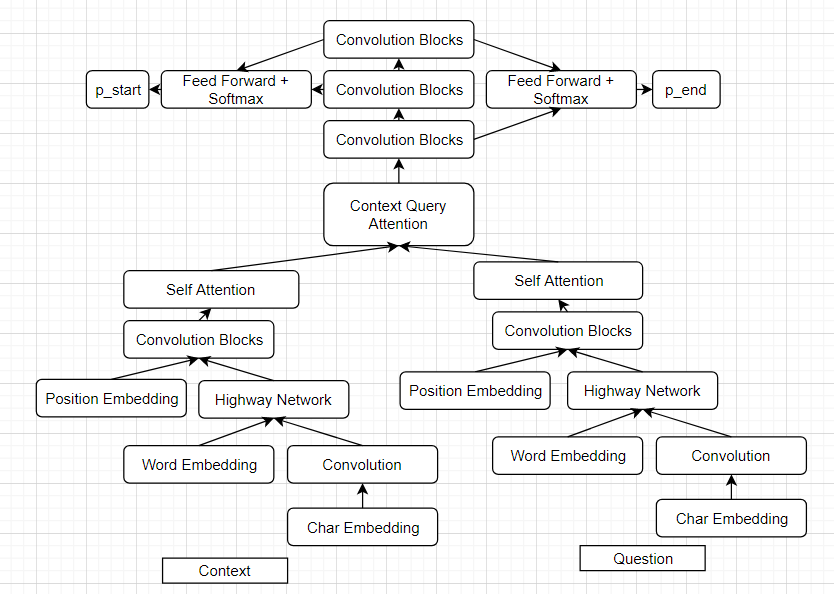

In [0]:
Image('https://raw.githubusercontent.com/ravichoudharyds/Natural-Language-Processing/master/HW5/qanet.PNG')

### 2.2.2 Performance of your Architecture

In [0]:
# -*- coding: utf-8 -*-
"""
Main file for training SQuAD reading comprehension model.
"""
from datetime import datetime
from QANet_PyTorch.model.QANet import QANet
from QANet_PyTorch.model.modules.ema import EMA
import shutil
import time
import math

In [0]:
# -*- coding: utf-8 -*-
"""
Trainer file for SQuAD dataset.
"""

class Trainer(object):

    def __init__(self, model, loss,
                 train_data_loader, dev_data_loader,
                 optimizer, scheduler, use_scheduler, epochs,
                 save_dir, use_ema, ema, resume):
        self.device = device

        self.model = model
        self.loss = loss
        self.optimizer = optimizer
        self.epochs = epochs
        self.save_dir = save_dir
        
        self.use_ema = use_ema
        self.ema = ema
        
        self.train_data_loader = train_data_loader
        self.dev_data_loader = dev_data_loader

        self.use_scheduler = use_scheduler
        self.scheduler = scheduler

        self.start_time = datetime.now().strftime('%b-%d_%H-%M')
        self.start_epoch = 1

        self.best_em = 0
        self.best_f1 = 0
        if resume:
            self._resume_checkpoint(resume)
            self.model = self.model.to(self.device)
            for state in self.optimizer.state.values():
                for k, v in state.items():
                    if isinstance(v, torch.Tensor):
                        state[k] = v.to(self.device)

    def train(self):
        patience = 0
        for epoch in range(self.start_epoch, self.epochs + 1):
            self.step = 0
            result = self._train_epoch(epoch)
            if self.use_scheduler:
                if self.scheduler.__class__ == torch.optim.lr_scheduler.MultiStepLR:
                    self.scheduler.step()
            is_best = False
            if result["f1"] > self.best_f1:
                is_best = True
            if result["f1"] == self.best_f1 and result["em"] > self.best_em:
                is_best = True
            self.best_f1 = max(self.best_f1, result["f1"])
            self.best_em = max(self.best_em, result["em"])

            if is_best:
                self._save_checkpoint(
                    epoch, result["f1"], result["em"], is_best)

    def _train_epoch(self, epoch):
        self.model.train()
        self.model.to(self.device)

        # initialize
        global_loss = 0.0
        last_step = self.step - 1
        last_time = time.time()

        # train over batches
        for batch_idx, batch in enumerate(self.train_data_loader):
            # get batch
            (context_wids,
             context_cids,
             question_wids,
             question_cids,
             y1,
             y2,
             ids) = batch
            batch_num, question_len = question_wids.size()
            _, context_len = context_wids.size()
            context_wids = context_wids.to(self.device)
            context_cids = context_cids.to(self.device)
            question_wids = question_wids.to(self.device)
            question_cids = question_cids.to(self.device)
            y1 = y1.to(self.device)
            y2 = y2.to(self.device)

            # calculate loss
            self.optimizer.zero_grad()
            p1, p2 = self.model(
                context_wids,
                context_cids,
                question_wids,
                question_cids)

            loss1 = self.loss(p1, y1)
            loss2 = self.loss(p2, y2)
            loss = torch.mean(loss1 + loss2)
            loss.backward()
            global_loss += loss.item()

            # update model
            self.optimizer.step()

            # update learning rate
            if self.use_scheduler:
                if self.scheduler.__class__ == torch.optim.lr_scheduler.LambdaLR:
                    self.scheduler.step()
                
            if self.use_ema and self.ema is not None:
                self.ema(self.model, self.step)

            # print training info
            if self.step % 500 == 499:
                used_time = time.time() - last_time
                step_num = self.step - last_step
                speed = self.train_data_loader.batch_size * \
                    step_num / used_time
                batch_loss = global_loss / step_num
                print(("step: {}/{} \t "
                       "epoch: {} \t "
                       "lr: {} \t "
                       "loss: {} \t "
                       "speed: {} examples/sec").format(
                           batch_idx, len(self.train_data_loader),
                           epoch,
                           self.optimizer.param_groups[0]['lr'],
                           batch_loss,
                           speed))
                global_loss = 0.0
                last_step = self.step
                last_time = time.time()
            self.step += 1

        metrics = self._valid_epoch(self.dev_data_loader)
        print("dev_em: %f \t dev_f1: %f" % (
              metrics["EM"], metrics["F1"]))

        result = {}
        result["em"] = metrics["EM"]
        result["f1"] = metrics["F1"]
        return result

    def _valid_epoch(self, data_loader):
        """
        Evaluate model over development dataset.
        Return the metrics: em, f1.
        """
        
        if self.use_ema and self.ema is not None:
            self.ema.assign(self.model)
        
        pred_dict = {}
        self.model.eval()
        answer_dict = {}
        with open(os.path.join(DIR, 'squad/data/dev_eval.json'), 'r') as fh:
            gold_dict = json_load(fh)
        with torch.no_grad():
            for batch_idx, batch in enumerate(data_loader):
                (context_wids,
                 context_cids,
                 question_wids,
                 question_cids,
                 y1,
                 y2,
                 ids) = batch
                context_wids = context_wids.to(self.device)
                context_cids = context_cids.to(self.device)
                question_wids = question_wids.to(self.device)
                question_cids = question_cids.to(self.device)
                y1 = y1.to(self.device)
                y2 = y2.to(self.device)

                p1, p2 = self.model(
                    context_wids,
                    context_cids,
                    question_wids,
                    question_cids)

                p1 = F.softmax(p1, dim=1)
                p2 = F.softmax(p2, dim=1)
                

            # Get F1 and EM scores
                starts, ends = util.discretize(p1, p2, 15, True)

                preds, _ = util.convert_tokens(gold_dict,
                                               ids.tolist(),
                                               starts.tolist(),
                                               ends.tolist(),
                                               True)
                pred_dict.update(preds)
        if self.use_ema and self.ema is not None:
            self.ema.resume(self.model)
        self.model.train()

        results = util.eval_dicts(gold_dict, pred_dict, True)
        return results


    def _save_checkpoint(self, epoch, f1, em, is_best):
        if self.use_ema and self.ema is not None:
            self.ema.assign(self.model)
        state = {
            'epoch': epoch,
            'state_dict': self.model.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'best_f1': self.best_f1,
            'best_em': self.best_em,
            'step': self.step + 1,
            'start_time': self.start_time}
        filename = os.path.join(
            self.save_dir,
            'QA_NET_' +
            'checkpoint_epoch{:02d}_f1_{:.5f}_em_{:.5f}.pth.tar'.format(
                epoch, f1, em))
        print("Saving checkpoint: {} ...".format(filename))
        if not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)
        torch.save(state, filename)
        if is_best:
            shutil.copyfile(
                filename, os.path.join(self.save_dir, 'qa_net_model_best.pth.tar'))
        if self.use_ema and self.ema is not None:
            self.ema.resume(self.model)
        return filename
    
    def _resume_checkpoint(self, resume_path):
        print("Loading checkpoint: {} ...".format(resume_path))
        checkpoint = torch.load(resume_path)
        self.start_epoch = checkpoint['epoch'] + 1
        self.model.load_state_dict(checkpoint['state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.best_f1 = checkpoint['best_f1']
        self.best_em = checkpoint['best_em']
        self.step = checkpoint['step']
        self.start_time = checkpoint['start_time']
        self.scheduler.last_epoch = checkpoint['epoch']
        print("Checkpoint '{}' (epoch {}) loaded".format(
            resume_path, self.start_epoch))


In [0]:
def main():
    glove_word = os.path.join(DIR, 'squad/data/word_emb.json')
    word_vectors = util.torch_from_json(glove_word)

    glove_char = os.path.join(DIR, 'squad/data/char_emb.json')
    char_vectors = util.torch_from_json(glove_char)

    # construct model
    model = QANet(
        word_vectors,
        char_vectors,
        400,
        50,
        128,
        num_head=8,
        train_cemb=True)
    model.summary()
    model.to(device)
    
    ema = EMA(0.9999)
    for name, param in model.named_parameters():
        if param.requires_grad:
            ema.register(name, param.data)
    
    train_path = os.path.join(DIR, 'squad/data/train.npz')
    train_loader = data.DataLoader(SQuAD(train_path),
                                   batch_size=8,
                                   shuffle=True,
                                   drop_last=True,
                                   collate_fn=collate_fn)

    dev_path = os.path.join(DIR, 'squad/data/dev.npz')
    dev_loader = data.DataLoader(SQuAD(dev_path),
                                   batch_size=64,
                                   shuffle=True,
                                   drop_last=True,
                                   collate_fn=collate_fn)


    # set optimizer and scheduler
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = optim.Adam(
        params=parameters,
        lr=0.001,
        betas=(0.8, 0.999),
        eps=1e-8,
        weight_decay=3e-6)
    cr = 1.0 / math.log(1000)
    scheduler = optim.lr_scheduler.LambdaLR(
        optimizer,
        lr_lambda=lambda ee: cr * math.log(ee + 1)
        if ee < 1000 else 1)
    
#     scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [3,6,10])

    # set loss, metrics
    loss = torch.nn.CrossEntropyLoss()


    # construct trainer
    # an identifier (prefix) for saved model
    identifier = type(model).__name__ + '_'
    trainer = Trainer(
    model, loss,
    train_data_loader=train_loader,
    dev_data_loader=dev_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    use_scheduler = False,
    epochs=30,
    save_dir='/scratch/rc3620/NLP_HW/Model_Files/128_EMA',
    use_ema = True,
    ema = ema,
    resume = '/scratch/rc3620/NLP_HW/Model_Files/128_EMA/qa_net_model_best.pth.tar')
    
    for param_group in trainer.optimizer.param_groups:
        param_group['lr'] = 0.0001
    
    
    # start training!
    start = datetime.now()
    trainer.train()
    print("Time of training model ", datetime.now() - start)


In [0]:
pretrained = True
if pretrained == False:
    main()
else:
    glove_word = os.path.join(DIR, 'squad/data/word_emb.json')
    word_vectors = util.torch_from_json(glove_word)

    glove_char = os.path.join(DIR, 'squad/data/char_emb.json')
    char_vectors = util.torch_from_json(glove_char)

    dev_path = os.path.join(DIR, 'squad/data/dev.npz')
    dev_loader = data.DataLoader(SQuAD(dev_path),
                                    batch_size=64,
                                    shuffle=True,
                                    drop_last=True,
                                    collate_fn=collate_fn)

    # construct model
    model = QANet(
        word_vectors,
        char_vectors,
        400,
        50,
        128,
        num_head=8,
        train_cemb=True)
    model = model.to(device)
    best_model = torch.load('/content/drive/My Drive/NLP_HW/HW5/QA_NET_checkpoint_epoch23_f1_67.61268_em_63.92663.pth.tar')
    model.load_state_dict(best_model['state_dict'])

###Ensembling Models

In [0]:
def evaluate_ensemble(model_list, bidaf_mask, data_loader, ensemble_model):
    """
    Evaluate model over development dataset.
    Return the metrics: em, f1.
    """
        
    pred_dict = {}
    ensemble_model.eval()
    for model in model_list:
        model.eval()
    answer_dict = {}
    with open(os.path.join(DIR, 'squad/data/dev_eval.json'), 'r') as fh:
        gold_dict = json_load(fh)
    with torch.no_grad():
        for batch_idx, batch in enumerate(data_loader):
            p1_list = []
            p2_list = []
            (context_wids,
            context_cids,
            question_wids,
            question_cids,
            y1,
            y2,
            ids) = batch
            context_wids = context_wids.to(device)
            context_cids = context_cids.to(device)
            question_wids = question_wids.to(device)
            question_cids = question_cids.to(device)
            y1 = y1.to(device)
            y2 = y2.to(device)
            for i, model in enumerate(model_list):
                if bidaf_mask[i]:
                    p1, p2 = model(
                    context_wids,
                    question_wids)
                    p1 = p1.exp()
                    p2 = p2.exp()
                else:
                    p1, p2 = model(
                    context_wids,
                    context_cids,
                    question_wids,
                    question_cids)
                p1_list.append(p1)
                p2_list.append(p2)

            p1 = F.softmax(ensemble_model(torch.stack(p1_list, dim = 2)).squeeze(), dim=1)
            p2 = F.softmax(ensemble_model(torch.stack(p2_list, dim = 2)).squeeze(), dim=1)
            
        # Get F1 and EM scores
            starts, ends = util.discretize(p1, p2, 15, True)

            preds, _ = util.convert_tokens(gold_dict,
                                            ids.tolist(),
                                            starts.tolist(),
                                            ends.tolist(),
                                            True)
            pred_dict.update(preds)

    results = util.eval_dicts(gold_dict, pred_dict, True)
    return results

In [0]:
## load your saved model

class ensemble_w(nn.Module):
    def __init__(self, model_num):
        super(ensemble_w, self).__init__()
        self.alpha = nn.Parameter(torch.ones([model_num, 1], requires_grad=True))
#         nn.init.xavier_normal_(self.alpha)
    
    def forward(self, p):
        return torch.matmul(p, self.alpha)
        

def ensemble_pred(model_list, bidaf_mask, train_loader, dev_loader, num_epoch = 10):
    """
    Evaluate model over development dataset.
    Return the metrics: em, f1.
    """
        
    for model in model_list:
        model.eval()
    
    ensemble_model = ensemble_w(len(model_list)).to(device)
    optimizer = optim.SGD(params=ensemble_model.parameters(),
                            lr=0.0001,
                            weight_decay=5e-2)
    criterion = torch.nn.CrossEntropyLoss()

    results = evaluate_ensemble(model_list, bidaf_mask, dev_loader, ensemble_model)
    print(results)
    best_f1 = results['F1']

    for i in range(num_epoch):
        ensemble_model.train()
        for batch_idx, batch in enumerate(train_loader):
            with torch.no_grad():
                p1_list = []
                p2_list = []
#                 print(batch_idx)
                (context_wids,
                context_cids,
                question_wids,
                question_cids,
                y1,
                y2,
                ids) = batch
                context_wids = context_wids.to(device)
                context_cids = context_cids.to(device)
                question_wids = question_wids.to(device)
                question_cids = question_cids.to(device)
                y1 = y1.to(device)
                y2 = y2.to(device)
                for i, model in enumerate(model_list):
                    if bidaf_mask[i]:
                        p1, p2 = model(
                        context_wids,
                        question_wids)
                        p1 = p1.exp()
                        p2 = p2.exp()
                    else:
                        p1, p2 = model(
                        context_wids,
                        context_cids,
                        question_wids,
                        question_cids)


                    p1_list.append(p1)
                    p2_list.append(p2)
        
            p1 = ensemble_model(torch.stack(p1_list, dim = 2)).squeeze()
            p2 = ensemble_model(torch.stack(p2_list, dim = 2)).squeeze()

            optimizer.zero_grad()
            
            loss1 = criterion(p1, y1)
            loss2 = criterion(p2, y2)
            loss = torch.mean(loss1 + loss2)
            if batch_idx%500 == 0:
                print(batch_idx," : ",loss.item())
            loss.backward()
            optimizer.step()

        results = evaluate_ensemble(model_list, bidaf_mask, dev_loader, ensemble_model)
        if results['F1'] > best_f1:
            best_model = ensemble_model.state_dict()
            best_f1 = results['F1']
        print(results)
    return best_model



In [7]:
glove_word = os.path.join(DIR, 'squad/data/word_emb.json')
word_vectors = util.torch_from_json(glove_word)

glove_char = os.path.join(DIR, 'squad/data/char_emb.json')
char_vectors = util.torch_from_json(glove_char)
model = QANet(
        word_vectors,
        char_vectors,
        400,
        50,
        128,
        num_head=8,
        train_cemb=False)
model = model.to(device)
best_model = torch.load('/content/drive/My Drive/NLP_HW/HW5/QA_NET_checkpoint_epoch22_f1_67.87415_em_64.11345.pth.tar')
model.load_state_dict(best_model['state_dict'])
model1 = QANet(
        word_vectors,
        char_vectors,
        400,
        50,
        128,
        num_head=8,
        train_cemb=True)
model1 = model1.to(device)
best_model = torch.load('/content/drive/My Drive/NLP_HW/HW5/QA_NET_checkpoint_epoch23_f1_67.61268_em_63.92663.pth.tar')
model1.load_state_dict(best_model['state_dict'])

model2 = BiDAF(word_vectors=word_vectors,
                  hidden_size=512,
                  drop_prob=0.2)
model2 = model2.to(device)
model2.load_state_dict(torch.load('/content/drive/My Drive/NLP_HW/HW5/Baseline_model.p'))

model3 = QANet(
        word_vectors,
        char_vectors,
        400,
        50,
        128,
        num_head=8,
        train_cemb=False)
model3 = model3.to(device)
best_model = torch.load('/content/drive/My Drive/NLP_HW/HW5/qa_net_model_best.pth.tar')
model3.load_state_dict(best_model['state_dict'])

model_list =[model, model1, model2, model3]
train_path = os.path.join(DIR, 'squad/data/train.npz')
train_loader = data.DataLoader(SQuAD(train_path),
                               batch_size=128,
                               shuffle=True,
                               drop_last=True,
                               collate_fn=collate_fn)
dev_path = os.path.join(DIR, 'squad/data/dev.npz')
dev_loader = data.DataLoader(SQuAD(dev_path),
                                batch_size=128,
                                shuffle=True,
                                drop_last=True,
                                collate_fn=collate_fn)
# ensemble_model = ensemble_pred(model_list, [False, False, True], train_loader, dev_loader)
ensemble_model = ensemble_w(len(model_list)).to(device)
evaluate_ensemble(model_list, [False, False, False], dev_loader, ensemble_model)

{'AvNA': 74.76222826086956, 'EM': 66.42323369565217, 'F1': 69.54282558264745}

In [0]:
## load your saved model

def evaluate(model, data_loader):
    """
    Evaluate model over development dataset.
    Return the metrics: em, f1.
    """
        
    pred_dict = {}
    model.eval()
    answer_dict = {}
    with open(os.path.join(DIR, 'squad/data/dev_eval.json'), 'r') as fh:
        gold_dict = json_load(fh)
    with torch.no_grad():
        for batch_idx, batch in enumerate(data_loader):
            (context_wids,
              context_cids,
              question_wids,
              question_cids,
              y1,
              y2,
              ids) = batch
            context_wids = context_wids.to(device)
            context_cids = context_cids.to(device)
            question_wids = question_wids.to(device)
            question_cids = question_cids.to(device)
            y1 = y1.to(device)
            y2 = y2.to(device)

            p1, p2 = model(
                context_wids,
                context_cids,
                question_wids,
                question_cids)

            p1 = F.softmax(p1, dim=1)
            p2 = F.softmax(p2, dim=1)
            

        # Get F1 and EM scores
            starts, ends = util.discretize(p1, p2, 15, True)

            preds, _ = util.convert_tokens(gold_dict,
                                            ids.tolist(),
                                            starts.tolist(),
                                            ends.tolist(),
                                            True)
            pred_dict.update(preds)

    results = util.eval_dicts(gold_dict, pred_dict, True)
    return results

def evaluate_on_dev_set(model, devloader):
    results = evaluate(model, devloader)
    return results

evaluate_on_dev_set(model, dev_loader)

{'AvNA': 74.20176630434783, 'EM': 63.994565217391305, 'F1': 67.68150163244056}

##### F1 Score on Dev Set: 67.68
##### EM on Dev Set: 63.99

## 3 Fine Tuning Bert

In [0]:
## load your saved model

# evaluate_on_dev_set(your_bert_model, dev_set)

##### F1 Score on Dev Set:
##### EM on Dev Set: 

## 4 Analysis

Example 1

Example 2

Example 3